# Pre-Trained Model 1:  DenseNet201 (pre-trained CNN from the Keras API)

Approach 1: Freeze the base DenseNet201 model, add a classifier head, and train the new model end-to-end using an “augmented” CIFAR10 dataset. Main model used for our analysis and report write up.

In [ ]:
#3.6 for A2
#Loadapre-trained model that you see fit(e.g.,aResNet)using existing libraries such as TensorFlow or PyTorch, and then freeze all the convolutional 
#layers and remove all the fully connected ones. Add a number of fully connected layers of your choice right after the convolutional layers. 
#Train only the fully connected layers of the pre-trained model on the CIFAR-10 dataset. How does this pre-trained model compare to the best 
#MLP in part 1 and to the regular CNN in part 5 in terms of the accuracy? How does it compare to the previous models in terms of the required 
#training time? Justify your choice of how many fully connected layers that you have added to the pre-trained model through careful experiments.

#Pre-trained model 1 DenseNet201 (pre-trained CNN from the Keras API):
#Source 1: https://medium.com/@pierre.beaujuge/classifying-images-from-the-cifar10-dataset-with-pre-trained-cnns-using-transfer-learning-9348f6d878a8
#Source 2: https://keras.io/api/applications/
#About a 50-60 minute runtime with 12-20 epochs and running with a colab GPU

#Tensorflow is needed to import the DenseNet201 model
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#The below function is used to preprocess the data from CIFAR10 so it is usable for DenseNet201
#the labels are one-hot encoded
def preprocess_data(X, Y):
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

# load the 50,000 training images for training and 10,000 test images for testing and validation
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

# This is where the data gets preprocessed
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)


170498071/170498071 [==============================] - 14s 0us/step


In [ ]:
#Weights are initialized as per the he et al. method
initializer = K.initializers.he_normal()
input_tensor = K.Input(shape=(32, 32, 3))

#Resize images to the image size for which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
model = K.applications.DenseNet201(include_top=False,
                                   weights='imagenet',
                                   input_tensor=resized_images,
                                   input_shape=(224, 224, 3),
                                   pooling='max',
                                   classes=1000)

#The biases and weights of the base model are freezed here. 
for layer in model.layers:
    layer.trainable = False
output = model.layers[-1].output

#Reshape the output feature map of the base model before passing the data on to the Dense layers of the classifier head
flatten = K.layers.Flatten()
output = flatten(output)
layer_256 = K.layers.Dense(units=256,
                           activation='elu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=10,
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=input_tensor, outputs=output)

74836368/74836368 [==============================] - 4s 0us/step


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
#Here, we compile the densely-connected head classifier with the base DenseNet201 model
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

#Reduce learning rate when val_accuracy has stopped improving, this will stop the runtime of the model so as we 
#do not use useless computation on a overfitted model
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)

#Stop training when val_accuracy has stopped improving, this will stop the runtime of the model so as we 
#do not use useless computation on a overfitted model with lower accuracy
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')

#Callback to save the Keras model and (best) weights obtained on an epoch basis. 
#Here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('cifar10.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

train_datagen = K.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32)
val_datagen = K.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32)
train_steps_per_epoch = x_train.shape[0] // 32
val_steps_per_epoch = x_test.shape[0] // 32

history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=20,
                    shuffle=True,
                    callbacks=[lr_reduce, early_stop, checkpoint],
                    verbose=1)

Epoch 1/20
1562/1562 [==============================] - ETA: 0s - loss: 3.5071 - accuracy: 0.7163
Epoch 1: val_accuracy improved from -inf to 0.86118, saving model to cifar10.h5
1562/1562 [==============================] - 304s 180ms/step - loss: 3.5071 - accuracy: 0.7163 - val_loss: 2.2318 - val_accuracy: 0.8612 - lr: 1.0000e-04
Epoch 2/20
1562/1562 [==============================] - ETA: 0s - loss: 2.0331 - accuracy: 0.8414
Epoch 2: val_accuracy improved from 0.86118 to 0.88111, saving model to cifar10.h5
1562/1562 [==============================] - 313s 200ms/step - loss: 2.0331 - accuracy: 0.8414 - val_loss: 1.6356 - val_accuracy: 0.8811 - lr: 1.0000e-04
Epoch 3/20
1562/1562 [==============================] - ETA: 0s - loss: 1.4820 - accuracy: 0.8689
Epoch 3: val_accuracy improved from 0.88111 to 0.89103, saving model to cifar10.h5
1562/1562 [==============================] - 275s 176ms/step - loss: 1.4820 - accuracy: 0.8689 - val_loss: 1.2288 - val_accuracy: 0.8910 - lr: 1.0000e-0

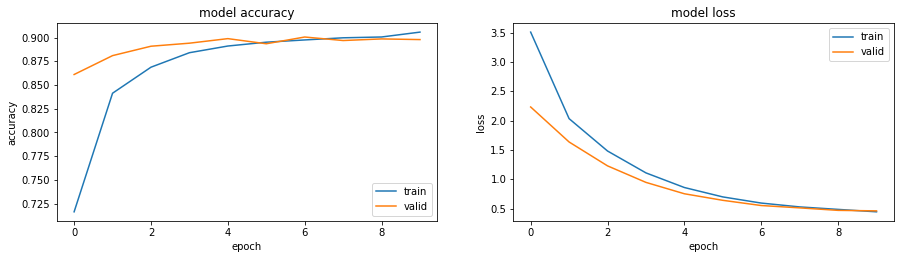

313/313 [==============================] - 46s 146ms/step - loss: 0.4611 - accuracy: 0.8976


[0.4611169397830963, 0.897599995136261]

In [ ]:
#Plot accuracy of the model and its loss figures
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

model.evaluate(x_test, y_test)

# Pre-Trained Model 2: DenseNet201 (pre-trained CNN from the Keras API)

Approach 2: Extract “bottleneck features” from the base DenseNet201 model, and use these to train the classifier head separately (w/o augmented dataset). This is the second, much faster approach. Results obtained were not great from our point of vue.

In [ ]:
input_tensor = K.Input(shape=(32, 32, 3))
#Resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=1000)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

In [ ]:
#Using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
#Repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

313/313 [==============================] - 42s 134ms/step


In [ ]:
#Weights are initialized as per the he et al. method
initializer = K.initializers.he_normal()
input_tensor = K.Input(shape=features_train.shape[1])
layer_256 = K.layers.Dense(units=256,
                           activation='elu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(input_tensor)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=10,
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=input_tensor, outputs=output)

In [ ]:
model.compile(
        optimizer=K.optimizers.Adam(learning_rate=1e4),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [ ]:
#Reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
#Stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
#Callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('cifar10.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [ ]:
history = model.fit(features_train, y_train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    callbacks=[lr_reduce, early_stop, checkpoint],
                    validation_data=(features_valid, y_test),
                    shuffle=True)

Epoch 1/20
1552/1563 [============================>.] - ETA: 0s - loss: 171706630144.0000 - accuracy: 0.0990
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to cifar10.h5
1563/1563 [==============================] - 7s 4ms/step - loss: 170558324736.0000 - accuracy: 0.0990 - val_loss: 815461184.0000 - val_accuracy: 0.1000 - lr: 10000.0000
Epoch 2/20
1550/1563 [============================>.] - ETA: 0s - loss: 17606330368.0000 - accuracy: 0.1014
Epoch 2: val_accuracy did not improve from 0.10000
1563/1563 [==============================] - 5s 3ms/step - loss: 18339905536.0000 - accuracy: 0.1014 - val_loss: 70855131136.0000 - val_accuracy: 0.1000 - lr: 10000.0000
Epoch 3/20
1554/1563 [============================>.] - ETA: 0s - loss: 8905139200.0000 - accuracy: 0.0995
Epoch 3: ReduceLROnPlateau reducing learning rate to 6000.0.

Epoch 3: val_accuracy did not improve from 0.10000
1563/1563 [==============================] - 6s 4ms/step - loss: 8862675968.0000 - accuracy: 

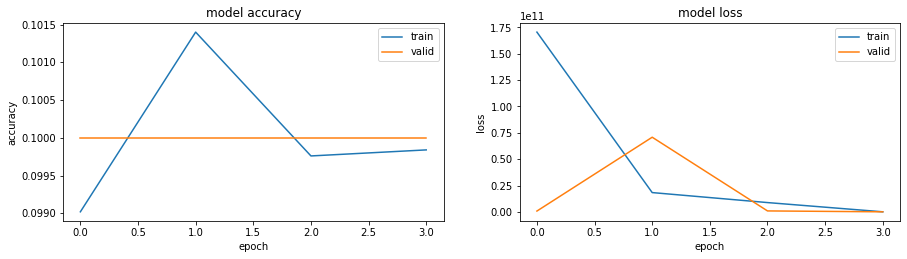

313/313 [==============================] - 1s 2ms/step - loss: 96492416.0000 - accuracy: 0.1000


[96492416.0, 0.10000000149011612]

In [ ]:
#Plot of the results
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

model.evaluate(features_valid, y_test)

# Pre-trained Model 3: Resnet50

In [ ]:
#Importing important libraries
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

#Loading ResNet50 with just the convolutional layers and not the dense layers 
#We train our new dataset on the new dense layers
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
#Load data directly from keras' dataset library
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
#To train the model, we make a few changes to the input data 
#The input image of Cifar10 is 32x32, we upscaled it 3 times before we can pass it through the ResNet layers. 
#After the images go through ResNet, we then flatten the processed input and pass it though 2 dense layers (with 128 and 64 neurons respectively). 
#Each layer has batch normalization beforehand and dropout coming out before the last layer, with softmax and 10 neurons. 
#We train for 5 epochs since the method is computationally very expensive

model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=5, batch_size=50, validation_data=(x_test, y_test))

Epoch 1/5
1000/1000 [==============================] - 638s 607ms/step - loss: 0.3350 - acc: 0.3456 - val_loss: 0.2409 - val_acc: 0.4389
Epoch 2/5
1000/1000 [==============================] - 616s 616ms/step - loss: 0.1581 - acc: 0.7040 - val_loss: 0.1633 - val_acc: 0.6610
Epoch 3/5
1000/1000 [==============================] - 609s 609ms/step - loss: 0.1123 - acc: 0.8072 - val_loss: 0.0989 - val_acc: 0.8069
Epoch 4/5
1000/1000 [==============================] - 616s 616ms/step - loss: 0.0892 - acc: 0.8531 - val_loss: 0.1236 - val_acc: 0.7754
Epoch 5/5
1000/1000 [==============================] - 616s 616ms/step - loss: 0.0742 - acc: 0.8801 - val_loss: 0.0790 - val_acc: 0.8488


<ipython-input-14-d244a8fa2bd8>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
<ipython-input-14-d244a8fa2bd8>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')


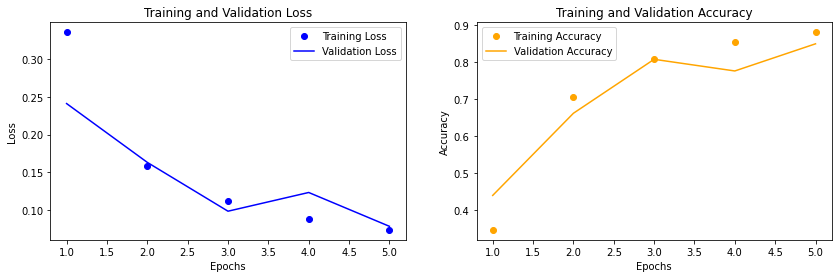

In [ ]:
#Draw the necessary plots

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Pre-trained Model 4: Resnet (Different Implementation)

In [1]:
# ---------------------------------------------------------------------------- #
# An implementation of https://arxiv.org/pdf/1512.03385.pdf                    #
# See section 4.2 for the model architecture on CIFAR-10                       #
# Some part of the code was referenced from below                              #
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py   #
# ---------------------------------------------------------------------------- #

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
torch.cuda.empty_cache()

#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Hyper-parameters
num_epochs = 12
learning_rate = 0.001

#Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

#CIFAR-10 dataset loading
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

#Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

#3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

#Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

#ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [2, 2, 2]).to(device)


#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    #Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

#Test the model
#Model.eval() will turn model to eval mode where batch normalization will not update its mean and std
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../../data/cifar-10-python.tar.gz to ../../data/
Epoch [1/12], Step [100/500] Loss: 1.7600
Epoch [1/12], Step [200/500] Loss: 1.3544
Epoch [1/12], Step [300/500] Loss: 1.2659
Epoch [1/12], Step [400/500] Loss: 1.2004
Epoch [1/12], Step [500/500] Loss: 1.0627
Epoch [2/12], Step [100/500] Loss: 1.0242
Epoch [2/12], Step [200/500] Loss: 1.0044
Epoch [2/12], Step [300/500] Loss: 1.0294
Epoch [2/12], Step [400/500] Loss: 0.9000
Epoch [2/12], Step [500/500] Loss: 0.9649
Epoch [3/12], Step [100/500] Loss: 0.8527
Epoch [3/12], Step [200/500] Loss: 0.8305
Epoch [3/12], Step [300/500] Loss: 0.8278
Epoch [3/12], Step [400/500] Loss: 0.7922
Epoch [3/12], Step [500/500] Loss: 0.7764
Epoch [4/12], Step [100/500] Loss: 0.8059
Epoch [4/12], Step [200/500] Loss: 0.6427
Epoch [4/12], Step [300/500] Loss: 1.0269
Epoch [4/12], Step [400/500] Loss: 0.8827
Epoch [4/12], Step [500/500] Loss: 0.6585
Epoch [5/12], Step [100/500] Loss: 0.8294
Epoch [5/12], Step [200/500] Loss: 0.8356
Epoch [5/12], St